In [2]:
import strawberryfields as sf
from strawberryfields.ops import Sgate

prog = sf.Program(1)
q = prog.register

with prog.context as q:
    Sgate(r=0.5, phi=0.2) | q[0]

eng = sf.Engine("gaussian")
result = eng.run(prog)

state = result.state
print(state)


<GaussianState: num_modes=1, pure=True, hbar=2>


In [7]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne

omega_0 = 1.0  
n = 1 
squeeze_param = 0.5 
N = 2 * (sf.math.sinh(squeeze_param))**2

prog = sf.Program(2)  

q = prog.register

with prog.context as q:
    Sgate(squeeze_param) | q[0]
    Sgate(squeeze_param) | q[1]

with prog.context as q:
    BSgate() | (q[0], q[1])

with prog.context as q:
    phase_shift = 2 * n * omega_0 
    Sgate(phase_shift) | q[0]

with prog.context as q:
    MeasureHomodyne(0) | q[0]

eng = sf.Engine("gaussian")
result = eng.run(prog)

output_state = result.state
parity_measurement = output_state.mean_photon(0)[0] 
delta_Pi = sf.math.sqrt(1 - parity_measurement**2)

sensing_error = (2 * n * sf.math.sqrt(N * (2 + N)))**-1

print("Parity measurement:", parity_measurement)
print("Sensing error (δΩ):", sensing_error)

Parity measurement: 0.0
Sensing error (δΩ): 0.425459064119661


In [9]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import tensorflow as tf
from tensorflow import keras

omega_0 = 1.0  
n = 1  
squeeze_param = 0.5 
N = 2 * (sf.math.sinh(squeeze_param))**2 

prog = sf.Program(2) 

q = prog.register

with prog.context as q:
    Sgate(squeeze_param) | q[0]
    Sgate(squeeze_param) | q[1]

with prog.context as q:
    BSgate() | (q[0], q[1])

with prog.context as q:
    phase_shift = 2 * n * omega_0
    Sgate(phase_shift) | q[0]

with prog.context as q:
    MeasureHomodyne(0) | q[0]

eng = sf.Engine("gaussian")
result = eng.run(prog)

output_state = result.state
parity_measurement = output_state.mean_photon(0)[0]  
delta_Pi = sf.math.sqrt(1 - parity_measurement**2)

sensing_error = (2 * n * sf.math.sqrt(N * (2 + N)))**-1

print("Parity measurement:", parity_measurement)
print("Sensing error (δΩ):", sensing_error)

input_data = tf.constant([[parity_measurement]], dtype=tf.float64) 
noise_factor = 0.1

noisy_input_data = tf.cast(input_data, dtype=tf.float32) + tf.random.normal(shape=tf.shape(input_data), stddev=noise_factor)

encoder = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu')
])

decoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

autoencoder = keras.Sequential([
    encoder,
    decoder
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer= optimizer, loss='mean_squared_error')

autoencoder.fit(noisy_input_data, input_data, epochs=10)

denoised_output = autoencoder.predict(noisy_input_data)

print("Denoised output:", denoised_output)

Parity measurement: 0.0
Sensing error (δΩ): 0.425459064119661
Epoch 1/10


2023-06-10 19:49:52.905556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 939ms/step - loss: 8.9981e-05
Epoch 2/10
1/1 [==============================] - 0s 14ms/step - loss: 6.6178e-05
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 4.5925e-05
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 2.9623e-05
Epoch 5/10
1/1 [==============================] - 0s 13ms/step - loss: 1.7926e-05
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 9.3284e-06
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 3.7812e-06
Epoch 8/10
1/1 [==============================] - 0s 13ms/step - loss: 8.2875e-07
Epoch 9/10
1/1 [==============================] - 0s 12ms/step - loss: 1.2620e-09
Epoch 10/10
1/1 [==============================] - 0s 68ms/step
Denoised output: [[0.00155825]]


2023-06-10 19:49:53.519831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [14]:

import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import tensorflow as tf
from tensorflow import keras
import numpy as np

omega_0 = 1.0  
n = 1 
squeeze_param = 0.5 
N = 2 * (sf.math.sinh(squeeze_param))**2  

datasets = []
for _ in range(100):
    prog = sf.Program(2) 

    q = prog.register

    with prog.context as q:
        Sgate(squeeze_param) | q[0]
        Sgate(squeeze_param) | q[1]

    with prog.context as q:
        BSgate() | (q[0], q[1])

    with prog.context as q:
        phase_shift = 2 * n * omega_0 
        Sgate(phase_shift) | q[0]

    with prog.context as q:
        MeasureHomodyne(0) | q[0]

    eng = sf.Engine("gaussian")
    result = eng.run(prog)
    output_state = result.state
    parity_measurement = output_state.mean_photon(0)[0] 
    datasets.append(parity_measurement)

input_data = tf.constant(datasets, dtype=tf.float64)
input_data = tf.reshape(input_data, (-1, 1))
noise_factor = 0.1 
noisy_input_data = tf.cast(input_data, dtype=tf.float32) + tf.random.normal(shape=tf.shape(input_data), stddev=noise_factor)

# Define the autoencoder model architecture
encoder = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu')
])

decoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

autoencoder = keras.Sequential([
    encoder,
    decoder
])

optimizer = tf.keras.optimizers.legacy.Adam()
autoencoder.compile(optimizer= optimizer, loss='mean_squared_error')

autoencoder.fit(noisy_input_data, input_data, epochs=10)

denoised_output = autoencoder.predict(noisy_input_data)

print("Denoised output:", denoised_output)

Epoch 1/10


2023-06-10 19:56:13.895461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 61ms/step - loss: 1.0255e-05
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 4.0783e-06
Epoch 3/10
4/4 [==============================] - 0s 10ms/step - loss: 1.2016e-06
Epoch 4/10
4/4 [==============================] - 0s 9ms/step - loss: 1.3448e-07
Epoch 5/10
4/4 [==============================] - 0s 10ms/step - loss: 3.2944e-07
Epoch 6/10
4/4 [==============================] - 0s 9ms/step - loss: 1.0317e-07
Epoch 7/10
4/4 [==============================] - 0s 9ms/step - loss: 5.2014e-08
Epoch 8/10
4/4 [==============================] - 0s 10ms/step - loss: 7.9380e-08
Epoch 9/10
4/4 [==============================] - 0s 9ms/step - loss: 1.2689e-08
Epoch 10/10
4/4 [==============================] - 0s 8ms/step
Denoised output: [[-7.92875362e-05]
 [-3.68467590e-05]
 [-3.00460670e-05]
 [-3.45382432e-05]
 [-3.83237202e-05]
 [-7.75146473e-05]
 [-2.86996656e-05]
 [-6.12664735e-07]
 [-2.70920864e-05]
 [-4.44730103e-05]
 [-1.38

2023-06-10 19:56:14.893086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Adeversarial Autoencoder for Denoising and signal recovery

In [2]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import numpy as np
import tensorflow as tf
from tensorflow import keras

squeeze_param = 0.5 
N = 2 * (sf.math.sinh(squeeze_param)) ** 2 
num_datasets = 100

parity_measurements = []

for _ in range(num_datasets):
    prog = sf.Program(2)  
    q = prog.register

    omega_0 = np.random.uniform(0, 2 * np.pi)
    n = np.random.randint(1, 10)  
    with prog.context as q:
        Sgate(squeeze_param) | q[0]
        Sgate(squeeze_param) | q[1]

   
    with prog.context as q:
        BSgate() | (q[0], q[1])
    with prog.context as q:
        phase_shift = 2 * n * omega_0 
        Sgate(phase_shift) | q[0]

    # Measure the parity operator at the output
    with prog.context as q:
        MeasureHomodyne(0) | q[0]
    eng = sf.Engine("gaussian")
    result = eng.run(prog)

    measurements = result.samples

    parity_measurement = np.mean(np.cos(measurements))

    parity_measurements.append(parity_measurement)


parity_measurements = np.array(parity_measurements)


#print("Parity measurement (Dataset 1):", parity_measurements[0])


input_data = tf.constant(parity_measurements, dtype=tf.float64)


input_data = tf.reshape(input_data, (-1, 1))

noise_factor = 0.5  

noisy_input_data = tf.cast(input_data, dtype=tf.float32) + tf.random.normal(shape=tf.shape(input_data), stddev=noise_factor)


encoder = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu')
])

decoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])


autoencoder = keras.Sequential([
    encoder,
    decoder
])

optimizer = tf.keras.optimizers.legacy.Adam()
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.fit(noisy_input_data, input_data, epochs=200)

denoised_output = autoencoder.predict(noisy_input_data)

print("Denoised output:", denoised_output)


Epoch 1/200
1/4 [======>.......................] - ETA: 0s - loss: 0.6971

2023-06-17 22:18:55.537624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 39ms/step - loss: 0.6687
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 0.5341
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 0.4230
Epoch 4/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3074
Epoch 5/200
4/4 [==============================] - 0s 9ms/step - loss: 0.2121
Epoch 6/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1542
Epoch 7/200
4/4 [==============================] - 0s 8ms/step - loss: 0.1513
Epoch 8/200
4/4 [==============================] - 0s 8ms/step - loss: 0.1620
Epoch 9/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1487
Epoch 10/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1266
Epoch 11/200
4/4 [==============================] - 0s 8ms/step - loss: 0.1181
Epoch 12/200
4/4 [==============================] - 0s 8ms/step - loss: 0.1153
Epoch 13/200
4/4 [==============================] - 0s 8ms/step - loss:

2023-06-17 22:19:02.699922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [3]:
parity_measurements

array([ 0.62124543,  0.99999989,  0.99737661, -0.52768659,  0.43282035,
        1.        ,  0.99999953,  0.99998664,  0.99999854,  0.99563312,
       -0.99743697,  1.        ,  0.9611734 ,  0.99999973,  0.28218376,
        0.85779705,  0.98847662,  0.99954939,  0.99851946,  1.        ,
        0.4341978 ,  0.95128825,  0.86855123, -0.99440178,  0.99180495,
        0.46735703,  0.99999999,  0.76393034,  0.76274812,  0.99999999,
       -0.15341231,  0.83845108,  0.67610679,  0.99999974,  0.73954561,
        0.24432847,  0.99999996,  0.69807664,  0.99999999, -0.85536848,
        0.92711515,  0.9981086 ,  0.9287747 ,  0.83054457,  0.11997262,
       -0.54687832, -0.13747179,  0.89172568,  0.97422336,  0.67845113,
       -0.51163459,  1.        ,  0.99991373, -0.96428782,  0.99999567,
        0.99997454,  0.99999996,  0.99999998,  0.99327343,  0.99999998,
        0.54381517,  0.99998796,  0.81759963,  0.48663752,  0.22266362,
        0.89548168, -0.33361446, -0.72153   ,  0.99322997, -0.38

In [4]:
mse = np.mean((denoised_output - input_data)**2)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.07348945184037696


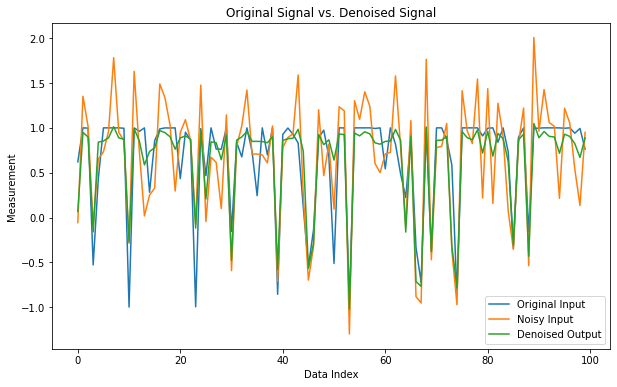

In [5]:
import matplotlib.pyplot as plt

denoised_output = denoised_output.reshape(-1)

plt.figure(figsize=(10, 6))
plt.plot(parity_measurements , label='Original Input')
plt.plot(noisy_input_data , label='Noisy Input')
plt.plot(denoised_output, label='Denoised Output')

plt.xlabel('Data Index')
plt.ylabel('Measurement')
plt.title('Original Signal vs. Denoised Signal')
plt.legend()
plt.savefig("/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope" + '/Original vs Denoised2.png', dpi=300, bbox_inches='tight')
plt.show()
#/Users/temitopeadeniyi/Documents/my documents

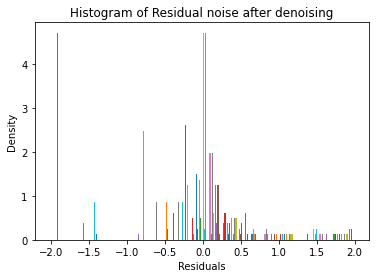

In [124]:
import matplotlib.pyplot as plt

residuals = input_data - denoised_output

# Plot histogram of residuals
plt.hist(residuals, bins=50, density=True)
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Histogram of Residual noise after denoising")
plt.savefig("/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope" + '/Histogram of Residual2.png', dpi=300, bbox_inches='tight')
plt.show()


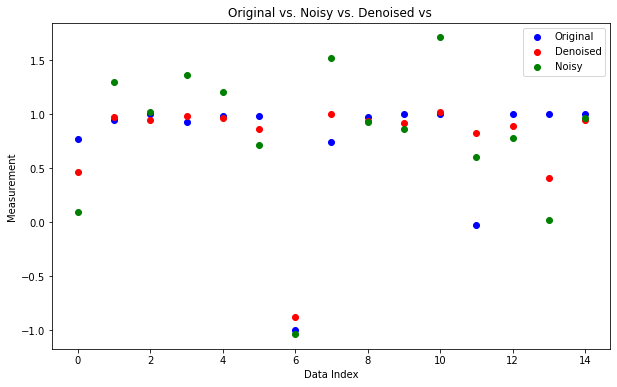

In [125]:
import matplotlib.pyplot as plt

subset_size = 15
subset_input_data = parity_measurements [:subset_size]
subset_denoised_output = denoised_output[:subset_size]
subset_noisy_input_data = noisy_input_data[:subset_size]

# Plot the subset of data
plt.figure(figsize=(10, 6))
plt.scatter(range(subset_size), subset_input_data, color='b', label='Original')
plt.scatter(range(subset_size), subset_denoised_output, color='r', label='Denoised')
plt.scatter(range(subset_size), subset_noisy_input_data, color='g', label='Noisy')
plt.xlabel('Data Index')
plt.ylabel('Measurement')
plt.title('Original vs. Noisy vs. Denoised vs ')
plt.legend()
plt.savefig("/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope" + '/Original vs Denoised Data.png', dpi=300, bbox_inches='tight')
plt.show()


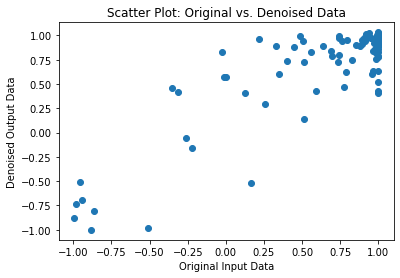

In [126]:
import matplotlib.pyplot as plt
import numpy as np

input_data_np = input_data.numpy()

input_data_flattened = input_data_np.flatten()
denoised_output_flattened = denoised_output.flatten()

plt.scatter(input_data_flattened, denoised_output_flattened)
plt.xlabel('Original Input Data')
plt.ylabel('Denoised Output Data')
plt.title('Scatter Plot: Original vs. Denoised Data')
plt.savefig("/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope" + '/Scatter Plot2.png', dpi=300, bbox_inches='tight')
plt.show()


In [61]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import numpy as np
import tensorflow as tf
from tensorflow import keras

squeeze_param = 0.5 
N = 2 * (sf.math.sinh(squeeze_param)) ** 2  
num_datasets = 100

parity_measurements = []


for _ in range(num_datasets):
    prog = sf.Program(2)  

    q = prog.register
    omega_0 = np.random.uniform(0, 2 * np.pi)
    n = np.random.randint(1, 10)  

    with prog.context as q:
        Sgate(squeeze_param) | q[0]
        Sgate(squeeze_param) | q[1]
        
    with prog.context as q:
        BSgate() | (q[0], q[1])

    # Apply the phase shift due to rotation
    with prog.context as q:
        phase_shift = 2 * n * omega_0  
        Sgate(phase_shift) | q[0]

    with prog.context as q:
        MeasureHomodyne(0) | q[0]

    # Run the program
    eng = sf.Engine("gaussian")
    result = eng.run(prog)

    # Extract the measurement result
    measurements = result.samples

    # Calculate the parity measurement
    parity_measurement = np.mean(np.cos(measurements))

    # Store the measurement in the list
    parity_measurements.append(parity_measurement)

parity_measurements = np.array(parity_measurements)

#print("Parity measurement (Dataset 1):", parity_measurements[0])

input_data = tf.constant(parity_measurements, dtype=tf.float64)

input_data = tf.reshape(input_data, (-1, 1))


noise_factor = 0.5  # Noise factor for denoising

# Add noise to the input data
noisy_input_data = tf.cast(input_data, dtype=tf.float32) + tf.random.normal(shape=tf.shape(input_data), stddev=noise_factor)

encoder = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu')
])

# Define the decoder model architecture
decoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

# Define the discriminator model architecture
discriminator = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


autoencoder = keras.Sequential([
    encoder,
    decoder
])
# Compile the autoencoder model
optimizer = tf.keras.optimizers.legacy.Adam()
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Compile the discriminator model
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')
num_epochs = 200
# Adversarial training loop
for epoch in range(num_epochs):
    # Train the discriminator
    discriminator.trainable = True
    real_data = input_data 
    encoded_data = encoder(real_data)  
    fake_data = decoder(encoded_data) 
    discriminator_loss_real = discriminator.train_on_batch(real_data, tf.ones_like(real_data))
    discriminator_loss_fake = discriminator.train_on_batch(fake_data, tf.zeros_like(fake_data))
    discriminator_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)

    # Train the autoencoder (generator)
    discriminator.trainable = False
    autoencoder_loss = autoencoder.train_on_batch(real_data, real_data)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Autoencoder Loss: {autoencoder_loss}, "
          f"Discriminator Loss: {discriminator_loss}")

# Denoise the input data using the trained autoencoder
denoised_output = autoencoder.predict(noisy_input_data)

print("Denoised output:", denoised_output)


2023-06-11 00:18:03.461702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 00:18:03.621683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 00:18:03.892541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/200, Autoencoder Loss: 0.6784904599189758, Discriminator Loss: 0.6977899074554443
Epoch 2/200, Autoencoder Loss: 0.6596558094024658, Discriminator Loss: 0.6899628341197968
Epoch 3/200, Autoencoder Loss: 0.638983964920044, Discriminator Loss: 0.6844070255756378
Epoch 4/200, Autoencoder Loss: 0.6191337704658508, Discriminator Loss: 0.6793490052223206
Epoch 5/200, Autoencoder Loss: 0.5983883738517761, Discriminator Loss: 0.6748144030570984
Epoch 6/200, Autoencoder Loss: 0.5765578150749207, Discriminator Loss: 0.6714611649513245
Epoch 7/200, Autoencoder Loss: 0.553000807762146, Discriminator Loss: 0.6683494448661804
Epoch 8/200, Autoencoder Loss: 0.5283652544021606, Discriminator Loss: 0.6656060814857483
Epoch 9/200, Autoencoder Loss: 0.5018308758735657, Discriminator Loss: 0.6638081967830658
Epoch 10/200, Autoencoder Loss: 0.47337326407432556, Discriminator Loss: 0.6627476215362549
Epoch 11/200, Autoencoder Loss: 0.44302603602409363, Discriminator Loss: 0.6620233356952667
Epoch 12

Epoch 91/200, Autoencoder Loss: 0.0004233055224176496, Discriminator Loss: 0.6961503326892853
Epoch 92/200, Autoencoder Loss: 0.0003700949891936034, Discriminator Loss: 0.6957947015762329
Epoch 93/200, Autoencoder Loss: 0.0003513297997415066, Discriminator Loss: 0.6954707205295563
Epoch 94/200, Autoencoder Loss: 0.0003452646196819842, Discriminator Loss: 0.695222407579422
Epoch 95/200, Autoencoder Loss: 0.0003408716875128448, Discriminator Loss: 0.6950505077838898
Epoch 96/200, Autoencoder Loss: 0.00033694333978928626, Discriminator Loss: 0.6949587464332581
Epoch 97/200, Autoencoder Loss: 0.0003282204270362854, Discriminator Loss: 0.6949430108070374
Epoch 98/200, Autoencoder Loss: 0.00031376859988085926, Discriminator Loss: 0.6949767768383026
Epoch 99/200, Autoencoder Loss: 0.00028900516917929053, Discriminator Loss: 0.6950301826000214
Epoch 100/200, Autoencoder Loss: 0.0002524723531678319, Discriminator Loss: 0.6950816512107849
Epoch 101/200, Autoencoder Loss: 0.00021191024279687554, 

Epoch 181/200, Autoencoder Loss: 6.8574113356589805e-06, Discriminator Loss: 0.6936885416507721
Epoch 182/200, Autoencoder Loss: 6.762491466361098e-06, Discriminator Loss: 0.693681389093399
Epoch 183/200, Autoencoder Loss: 6.663047315669246e-06, Discriminator Loss: 0.6936744451522827
Epoch 184/200, Autoencoder Loss: 6.562101589224767e-06, Discriminator Loss: 0.6936675906181335
Epoch 185/200, Autoencoder Loss: 6.4651026150386315e-06, Discriminator Loss: 0.6936616003513336
Epoch 186/200, Autoencoder Loss: 6.371196377585875e-06, Discriminator Loss: 0.6936560869216919
Epoch 187/200, Autoencoder Loss: 6.279873105086153e-06, Discriminator Loss: 0.6936517655849457
Epoch 188/200, Autoencoder Loss: 6.1935256780998316e-06, Discriminator Loss: 0.6936478018760681
Epoch 189/200, Autoencoder Loss: 6.111202310421504e-06, Discriminator Loss: 0.6936433613300323
Epoch 190/200, Autoencoder Loss: 6.027909421391087e-06, Discriminator Loss: 0.6936379671096802
Epoch 191/200, Autoencoder Loss: 5.9423914535727

2023-06-11 00:18:10.057694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [63]:
mse = np.mean((denoised_output - input_data)**2)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.16682963601528403


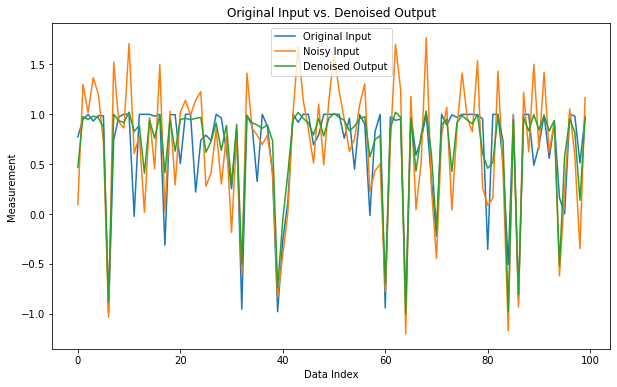

In [127]:
import matplotlib.pyplot as plt

denoised_output = denoised_output.reshape(-1)

plt.figure(figsize=(10, 6))
plt.plot(parity_measurements , label='Original Input')
plt.plot(noisy_input_data , label='Noisy Input')
plt.plot(denoised_output, label='Denoised Output')
plt.xlabel('Data Index')
plt.ylabel('Measurement')
plt.title('Original Input vs. Denoised Output')
plt.legend()
plt.show()

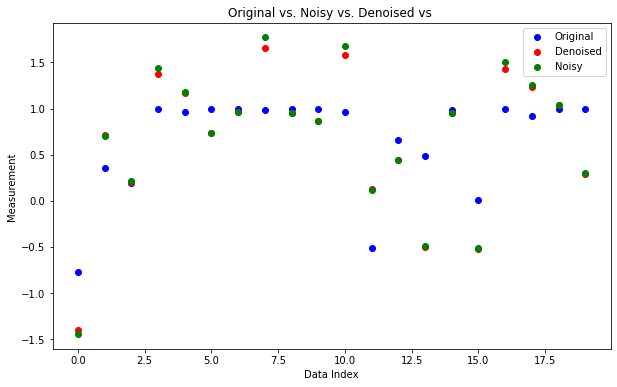

In [66]:
import matplotlib.pyplot as plt

subset_size = 20
subset_input_data = parity_measurements [:subset_size]
subset_denoised_output = denoised_output[:subset_size]
subset_noisy_input_data = noisy_input_data[:subset_size]

# Plot the subset of data
plt.figure(figsize=(10, 6))
plt.scatter(range(subset_size), subset_input_data, color='b', label='Original')
plt.scatter(range(subset_size), subset_denoised_output, color='r', label='Denoised')
plt.scatter(range(subset_size), subset_noisy_input_data, color='g', label='Noisy')
plt.xlabel('Data Index')
plt.ylabel('Measurement')
plt.title('Original vs. Noisy vs. Denoised vs ')
plt.legend()
plt.savefig("/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope" + '/Original vs Denoised Data.png', dpi=300, bbox_inches='tight')
plt.show()


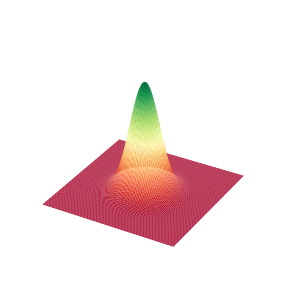

In [135]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import numpy as np

squeeze_param = 0.5  

# Create a quantum program
prog = sf.Program(2)  

q = prog.register

with prog.context as q:
    Sgate(squeeze_param) | q[0]
    Sgate(squeeze_param) | q[1]

with prog.context as q:
    BSgate() | (q[0], q[1])

with prog.context as q:
    omega_0 = np.random.uniform(0, 2 * np.pi)
    n = np.random.randint(1, 10)  
    phase_shift = 2 * n * omega_0  
    Sgate(phase_shift) | q[0]

# Measure the parity operator at the output
with prog.context as q:
    MeasureHomodyne(0) | q[0]

eng.reset()
state = eng.run(prog).state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

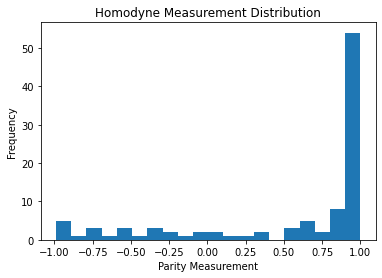

In [134]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import numpy as np
import matplotlib.pyplot as plt

squeeze_param = 0.5 
N = 2 * (sf.math.sinh(squeeze_param)) ** 2  
num_datasets = 100

parity_measurements = []

for _ in range(num_datasets):
    prog = sf.Program(2) 

    # Create a quantum register
    q = prog.register

    omega_0 = np.random.uniform(0, 2 * np.pi)
    n = np.random.randint(1, 10)
   
    with prog.context as q:
        Sgate(squeeze_param) | q[0]
        Sgate(squeeze_param) | q[1]

    with prog.context as q:
        BSgate() | (q[0], q[1])

    with prog.context as q:
        phase_shift = 2 * n * omega_0  
        Sgate(phase_shift) | q[0]

    # Measure the parity operator at the output
    with prog.context as q:
        MeasureHomodyne(0) | q[0]

    eng = sf.Engine("gaussian")
    result = eng.run(prog)

    measurements = result.samples

    parity_measurement = np.mean(np.cos(measurements))

    parity_measurements.append(parity_measurement)

parity_measurements = np.array(parity_measurements)

# Visualize the homodyne measurement
plt.hist(parity_measurements, bins=20)
plt.xlabel("Parity Measurement")
plt.ylabel("Frequency")
plt.title("Homodyne Measurement Distribution")
plt.show()


In [137]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureHomodyne
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Parameters
squeeze_param = 0.5  
N = 2 * (sf.math.sinh(squeeze_param)) ** 2  
num_datasets = 100

parity_measurements = []

for _ in range(num_datasets):
    prog = sf.Program(2)  
   
    q = prog.register

    omega_0 = np.random.uniform(0, 2 * np.pi)
    n = np.random.randint(1, 10)  

    with prog.context as q:
        Sgate(squeeze_param) | q[0]
        Sgate(squeeze_param) | q[1]

    with prog.context as q:
        BSgate() | (q[0], q[1])

    with prog.context as q:
        phase_shift = 2 * n * omega_0  
        Sgate(phase_shift) | q[0]

    #with prog.context as q:
        #MeasureHomodyne(0) | q[0]

    eng = sf.Engine("gaussian")
    result = eng.run(prog)

    measurements = result.samples

    parity_measurement = np.mean(np.cos(measurements))

    parity_measurements.append(parity_measurement)

parity_measurements = np.array(parity_measurements)

print(prog.draw_circuit())


['/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope/circuit_tex/output_2023_June_11_08:10PM.tex', '\\documentclass{article}\n\\pagestyle{empty}\n\\usepackage{qcircuit}\n\\begin{document}\n\\Qcircuit {\n & \\gate{S}  & \\multigate{1}{BS}  & \\gate{S}  & \\qw \\\\\n & \\gate{S}  & \\ghost{BS}  & \\qw  & \\qw \\\\\n}\n\\end{document}']


/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars


In [138]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate
import numpy as np

squeeze_param = 0.5 
num_modes = 2

prog = sf.Program(num_modes) 

q = prog.register

with prog.context as q:
    Sgate(squeeze_param) | q[0]
    Sgate(squeeze_param) | q[1]

with prog.context as q:
    BSgate() | (q[0], q[1])

eng = sf.Engine("gaussian")
result = eng.run(prog)

print(prog.draw_circuit())


['/Users/temitopeadeniyi/Documents/my documents/NASA Gyroscope/circuit_tex/output_2023_June_11_08:10PM.tex', '\\documentclass{article}\n\\pagestyle{empty}\n\\usepackage{qcircuit}\n\\begin{document}\n\\Qcircuit {\n & \\gate{S}  & \\multigate{1}{BS}  & \\qw \\\\\n & \\gate{S}  & \\ghost{BS}  & \\qw \\\\\n}\n\\end{document}']


In [142]:
import qiskit
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

tex_content = '\\documentclass{article}\n\\pagestyle{empty}\n\\usepackage{qcircuit}\n\\begin{document}\n\\Qcircuit {\n & \\gate{S}  & \\multigate{1}{BS}  & \\qw \\\\\n & \\gate{S}  & \\ghost{BS}  & \\qw \\\\\n}\n\\end{document}'

image_path = "circuit.png"
circuit_drawer(tex_content, output=image_path)

# Display the saved image
image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


AttributeError: 'str' object has no attribute 'clbits'

In [143]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

prog = sf.Program(3)

alpha = 1+0.5j
r = np.abs(alpha)
phi = np.angle(alpha)

with prog.context as q:

    Coherent(r, phi) | q[0]
    Squeezed(-2) | q[1]
    Squeezed(2) | q[2]

    BS = BSgate(pi/4, pi)
    BS | (q[1], q[2])
    BS | (q[0], q[1])

    MeasureX | q[0]
    MeasureP | q[1]

    # the measurements
    Xgate(sqrt(2) * q[0].par) | q[2]
    Zgate(sqrt(2) * q[1].par) | q[2]

eng = sf.Engine('fock', backend_options={'cutoff_dim': 15})
result = eng.run(prog, shots=1, modes=None, compile_options={})